The purpose of this project is to model the career lengths of NFL running backs.  It has been said in the sports media that NFL running backs have short career lengths.  To see if that statement is true the career lifetimes of NFL running backs from 1970-2014 will be modeled using the survival analysis methods of Kaplan-Meier Estimation and Cox Regression.  Cox Regression will be used to predict career lengths using starting age, total number of plays, total TD's, total yards gained and the number of fumbles.  Additionally, we will try to develop an aging curve based on the Crow-AMSAA reliability growth model.

In [13]:
#importing packages
import pandas as pd
import math
import numpy as np
from sklearn.cross_validation import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import k_fold_cross_validation
%matplotlib inline

In [14]:
rushingData = pd.read_csv('C:/Users/BAC/Documents/Kojak Project/rushingDataCoxRg2.csv')# reading in file

In [15]:
rushingData.tail()

,name,count,min,max,min.1,sum,sum.1,sum.2,sum.3,sum.4,sum.5,sum.6,sum.7,sum.8
1222,Woody Thompson,3,1975,1977,23,35,242,877,0,42,259,1136,1,10
1223,Zac Stacy,3,2013,2015,22,35,357,1355,70,53,358,1713,10,3
1224,Zach Zenner,1,2015,2015,24,6,17,60,3,2,11,71,0,0
1225,Zachary Dixon,1,1982,1982,26,9,58,249,0,20,185,434,1,2
1226,Zack Crockett,13,1995,2007,23,175,510,1701,144,96,680,2381,38,15


In [16]:
rushingData=rushingData.rename(columns={'count':'seasons','min':'start_yr','max':'end_yr','min.1':'start_age','sum':'tot_games','sum.1':'tot_rushatt','sum.2':'tot_rushyds','sum.3':'recpt_tgt',
                                        'sum.4':'tot_reccaught','sum.5':'tot_recyds','sum.6':'tot_yscm','sum.7':'tot_rrtd','sum.8':'tot_fumbles'})
rushingData.head(n=20)

,name,seasons,start_yr,end_yr,start_age,tot_games,tot_rushatt,tot_rushyds,recpt_tgt,tot_reccaught,tot_recyds,tot_yscm,tot_rrtd,tot_fumbles
0,A.B. Brown,3,1989,1992,24,24,37,113,6,8,40,153,0,1
1,Aaron Craver,7,1992,1999,24,89,223,908,234,162,1297,2205,13,8
2,Aaron Hayden,3,1995,1997,22,31,215,784,11,8,74,858,4,11
3,Aaron Stecker,10,2000,2009,25,129,386,1526,216,166,1175,2701,11,10
4,Adam Walker,1,1995,1995,27,13,14,44,21,11,78,122,1,2
5,Adger Armstrong,5,1981,1985,24,64,58,231,0,80,710,941,9,3
6,Adrian Murrell,9,1993,2003,23,122,1375,5199,317,214,1369,6568,28,26
7,Adrian Peterson1,8,2002,2009,23,106,311,1283,102,78,665,1948,8,6
8,Adrian Peterson2,9,2007,2015,22,120,2381,11675,328,238,1937,13612,102,38
9,Adrian Wright,1,1987,1987,26,3,37,112,0,13,98,210,1,1


In [20]:
totatt1=rushingData['tot_rushatt']+rushingData['tot_reccaught']
totatt2=rushingData['tot_rushatt']+rushingData['recpt_tgt']
rushingData['tot_attempts']=np.where(rushingData['start_yr'] < 1992,totatt1,totatt2)
rushingData['yscmpatt']=rushingData.tot_yscm/rushingData.tot_attempts
rushingData['rushydspatt'] = rushingData.tot_rushyds/rushingData.tot_attempts
rushingData['recydspatt'] = rushingData.tot_recyds/rushingData.tot_reccaught
rushingData['fmbpatt'] = rushingData.tot_fumbles/rushingData.tot_attempts
rushingData['retire_released'] = np.where(rushingData['end_yr']<=2014, 1,0)
rushingData['Rcensored'] = np.where(rushingData['end_yr']==2015, 1, 0)
rushingData['Lcensored'] = np.where(rushingData['start_yr']==1969, 1,0)
#rushingData.insert(5,'Season_len',np.where(rushingData['end_yr']<1978,14,16))
rushdfSeasonSort=rushingData.sort_values(by = ['seasons'])
rushdfSeasonSort.head(n=10)

,name,seasons,start_yr,end_yr,start_age,tot_games,tot_rushatt,tot_rushyds,recpt_tgt,tot_reccaught,...,tot_rrtd,tot_fumbles,tot_attempts,rushydspatt,recydspatt,fmbpatt,retire_released,Rcensored,Lcensored,yscmpatt
1151,Tony Hollings,1,2003,2003,22,14,38,102,6,2,...,0,2,44,2.318182,12.500000,0.045455,1,0,0,2.886364
766,Louis Jackson,1,1981,1981,23,11,27,68,0,3,...,1,1,30,2.266667,8.333333,0.033333,1,0,0,3.100000
769,Lynell Hamilton,1,2009,2009,24,9,35,125,7,5,...,2,0,42,2.976190,9.600000,0.000000,1,0,0,4.119048
294,Deon Anderson,1,2008,2008,25,14,2,3,3,2,...,1,0,5,0.600000,3.500000,0.000000,1,0,0,2.000000
774,Manase Tonga,1,2011,2011,27,11,1,12,4,3,...,0,0,5,2.400000,6.000000,0.000000,1,0,0,6.000000
289,Delone Carter,1,2011,2011,24,16,101,377,8,5,...,2,3,109,3.458716,3.600000,0.027523,1,0,0,3.623853
288,Dee Brown,1,2002,2002,24,14,102,360,33,17,...,5,4,135,2.666667,5.058824,0.029630,1,0,0,3.303704
284,Davone Bess,1,2011,2011,26,16,2,9,86,51,...,3,5,88,0.102273,10.529412,0.056818,1,0,0,6.204545
281,David Palmer,1,1999,1999,27,8,3,12,7,4,...,0,5,10,1.200000,6.250000,0.500000,1,0,0,3.700000
280,David McCluskey,1,1987,1987,24,3,29,94,0,1,...,1,2,30,3.133333,8.000000,0.066667,1,0,0,3.400000


In [21]:
rushdfGamesSort = rushingData.sort_values(by = ['tot_games'])
rushdfGamesSort = rushdfGamesSort[rushdfGamesSort.Lcensored != 1 ]
rushdfGamesSort.head()

,name,seasons,start_yr,end_yr,start_age,tot_games,tot_rushatt,tot_rushyds,recpt_tgt,tot_reccaught,...,tot_rrtd,tot_fumbles,tot_attempts,rushydspatt,recydspatt,fmbpatt,retire_released,Rcensored,Lcensored,yscmpatt
724,Lavale Thomas,1,1987,1987,24,1,5,19,0,2,...,1,0,7,2.714286,26.000000,0.000,1,0,0,10.142857
605,John Skibinski,1,1979,1979,24,1,3,10,0,1,...,0,0,4,2.500000,4.000000,0.000,1,0,0,3.500000
745,Leonard Moore,1,1987,1987,24,1,4,11,0,1,...,0,0,5,2.200000,8.000000,0.000,1,0,0,3.800000
582,Jimmy Smith,1,1987,1987,27,1,7,13,0,0,...,0,0,7,1.857143,NaN,0.000,1,0,0,1.857143
1031,Sam Harrell,1,1987,1987,30,1,5,8,0,3,...,0,1,8,1.000000,6.666667,0.125,1,0,0,3.500000


In [85]:
 sss = StratifiedShuffleSplit(rushdfGamesSort['retire_released'], 1, test_size=0.2, random_state=0)
for train_indx, test_indx in sss:
    
    train = rushdfGamesSort.ix[train_indx]
    X_train = train[['name','seasons','start_yr','end_yr','start_age','tot_games','tot_rushatt','tot_rushyds','rushydspatt','recpt_tgt','tot_reccaught','tot_attempts','tot_recyds','recydspatt','tot_yscm','yscmpatt','tot_rrtd','tot_fumbles','fmbpatt']]
    y_train = train['retire_released']
    
    test = rushdfGamesSort.ix[test_indx]
    X_test = test[['name','seasons','start_yr','end_yr','start_age','tot_games','tot_rushatt','tot_rushyds','rushydspatt','recpt_tgt','tot_reccaught','tot_attempts','tot_recyds','recydspatt','tot_yscm','yscmpatt','tot_rrtd','tot_fumbles','fmbpatt']]
    y_test = test['retire_released']
    
train = pd.concat([X_train, y_train],join = 'outer', axis=1)
test =  pd.concat([X_test, y_test],join = 'outer', axis=1) 

X = patsy.dmatrix('start_age+tot_rushatt+rushydspatt+tot_reccaught+recydspatt+tot_rrtd-1',train,return_type='dataframe')
X['T'] = train['seasons']
X['E'] = train['retire_released']

cxf=CoxPHFitter()
scores = k_fold_cross_validation(cxf, X, 'T', event_col='E', k=10)
#cxf.fit(X,'T',event_col = 'E')

In [86]:
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.84446232233842855, 0.86907929749866952, 0.85428875865743203, 0.87134964483030786, 0.833516785910842, 0.85748987854251013, 0.8770799785292539, 0.88130081300813012, 0.85499865987670864, 0.85626502805236437]
0.859983116724
0.0140618561835


In [87]:
cxf.print_summary() 

n=868, number of events=779

                    coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
start_age      2.454e-01  1.278e+00 3.704e-02  6.624e+00 3.500e-11   1.728e-01   3.180e-01  ***
tot_rushatt    3.138e-01  1.369e+00 1.168e-01  2.685e+00 7.247e-03   8.470e-02   5.428e-01   **
rushydspatt   -1.691e-01  8.444e-01 4.692e-02 -3.605e+00 3.124e-04  -2.611e-01  -7.715e-02  ***
tot_reccaught -9.604e-01  3.827e-01 8.108e-02 -1.184e+01 2.289e-32  -1.119e+00  -8.015e-01  ***
recydspatt     2.666e-01  1.305e+00 3.777e-02  7.057e+00 1.701e-12   1.925e-01   3.406e-01  ***
tot_rrtd      -5.917e-01  5.534e-01 1.229e-01 -4.816e+00 1.464e-06  -8.326e-01  -3.509e-01  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.858


In [ ]:
cxf.baseline_hazard_

In [ ]:
cxf.hazards_

In [68]:
cxf.predict_survival_function(X_test)

TypeError: predict_survival_function() got an unexpected keyword argument 'label'

In [60]:
ix = (rushdfGamesSort['name']=='Jamaal Charles')
Charles = X_train.ix[ix]

In [89]:
data = pd.DataFrame([[28], [37],[-62],[-37], [31],[-45]],index=['Start Age','Total Rushing Attempts' ,'Rush Yds/Attempt', 'Total Passes Caught','Receiving Yds/Passes Caught', 'Rush & Rec. TD'],columns=['%Relative Risk'])
sorted_df = data.sort(['%Relative Risk'],ascending = True)
sorted_df

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,%Relative Risk
Rush Yds/Attempt,-62
Rush & Rec. TD,-45
Total Passes Caught,-37
Start Age,28
Receiving Yds/Passes Caught,31
Total Rushing Attempts,37


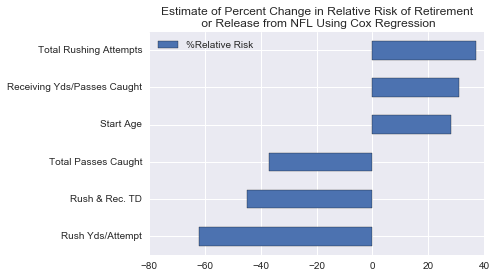

In [90]:
sorted_df.plot(kind='barh')
plt.title("Estimate of Percent Change in Relative Risk of Retirement\n or Release from NFL Using Cox Regression")

In [91]:
cxf.predict_survival_function(Charles)

,488
event_at,
0.0,1.000000
1.0,0.995791
2.0,0.990825
3.0,0.984682
4.0,0.976547
5.0,0.964538
6.0,0.948098
7.0,0.919578
8.0,0.880368


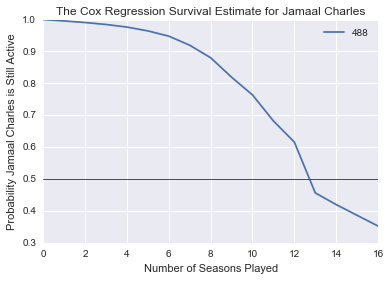

In [94]:
ax = plt.subplot(1,1,1)

cxf.predict_survival_function(Charles).plot(ax=ax)
plt.axhline(y=0.50, linewidth = 1, color = 'r')
plt.title("The Cox Regression Survival Estimate for Jamaal Charles")
plt.xlabel("Number of Seasons Played")
plt.ylabel("Probability Jamaal Charles is Still Active");